# Técnicas de Deep Learning de séries temporais na previsão de bitcoins

Para este trabalho usamos o dataset disponivel em: https://www.kaggle.com/mczielinski/bitcoin-historical-data

Com este trabalho pretendemos resolver um problema single-step univariável, ou seja, através de uma sequencia de valores de bitcoins prever o valor da bitcoin seguinte

Neste trabalho usamos uma série de biblioteca disponibilizadas pelo python de forma a simplificar a resolução do nosso problema

Biblioteca importadas:

pandas - manipulação de analise de dados            

numpy - implementação de vetores e matrizes 

tensorflow - machine learning package

sklearn - machine learning package

matplotlib - visualização e geração de graficos

sweetviz - Exploratory Data Analysis

autoviz - visualização e geração de graficos

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import sweetviz as sv
from autoviz.AutoViz_Class import AutoViz_Class

#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91190530)
#for an easy reset backend session state
tf.keras.backend.clear_session()

Em primeiro lugar foi necessário ler os dados do ficheiro csv para isso criamos a função  load_dataset() que permite através de um filepath ler os dados de um ficheiro para um pandas dataframe

In [19]:
#load dataset to pandas dataframe
def load_dataset(path):
  return pd.read_csv(path)

df = load_dataset("/content/drive/MyDrive/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

# ANÁLISE EXPLORATÓRIA

Aqui começamos a realizar a exploração dos dados

In [20]:
'''INFORMAÇÕES GERAIS DO DATASET'''

#dataset info
print("Info \n")
df.info()

print("\n----------------------------------------------------------------------\n")

'''ESTATISTICA DESCRITIVA DO DATASET (mínimo, máximo, média, desvio padrão, contagem, os quantiles de 25%, 50% e 75%)'''

print("Describe \n")
df.describe(include='all')

Info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB

----------------------------------------------------------------------

Describe 



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


Aqui utilizamos a bibloteca sweetviz que nos fornece um monte de informações acerca do dataset através de uma página HTML

In [21]:
'''EXPLORAÇÃO MAIS PROFUNDA DO DATASET - EM UMA PÁGINA HTML'''

analise = sv.analyze(df)
analise.show_html('DataExploration_BitCoin.html')

                                             |          | [  0%]   00:00 -> (? left)

Report DataExploration_BitCoin.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


A partir daqui realizamos alguns gráficos para termos uma visão melhor dos dados do dataset

Shape of your Data Set: (4857377, 8)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  7
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    8 Predictors classified...
        This does not include the Target column(s)
        1 variables removed since they were ID or low-information variables
Since Number of Rows in data 4857377 exceeds maximum, randomly sampling 150000 rows for EDA...
Number of All Scatter Plots = 28


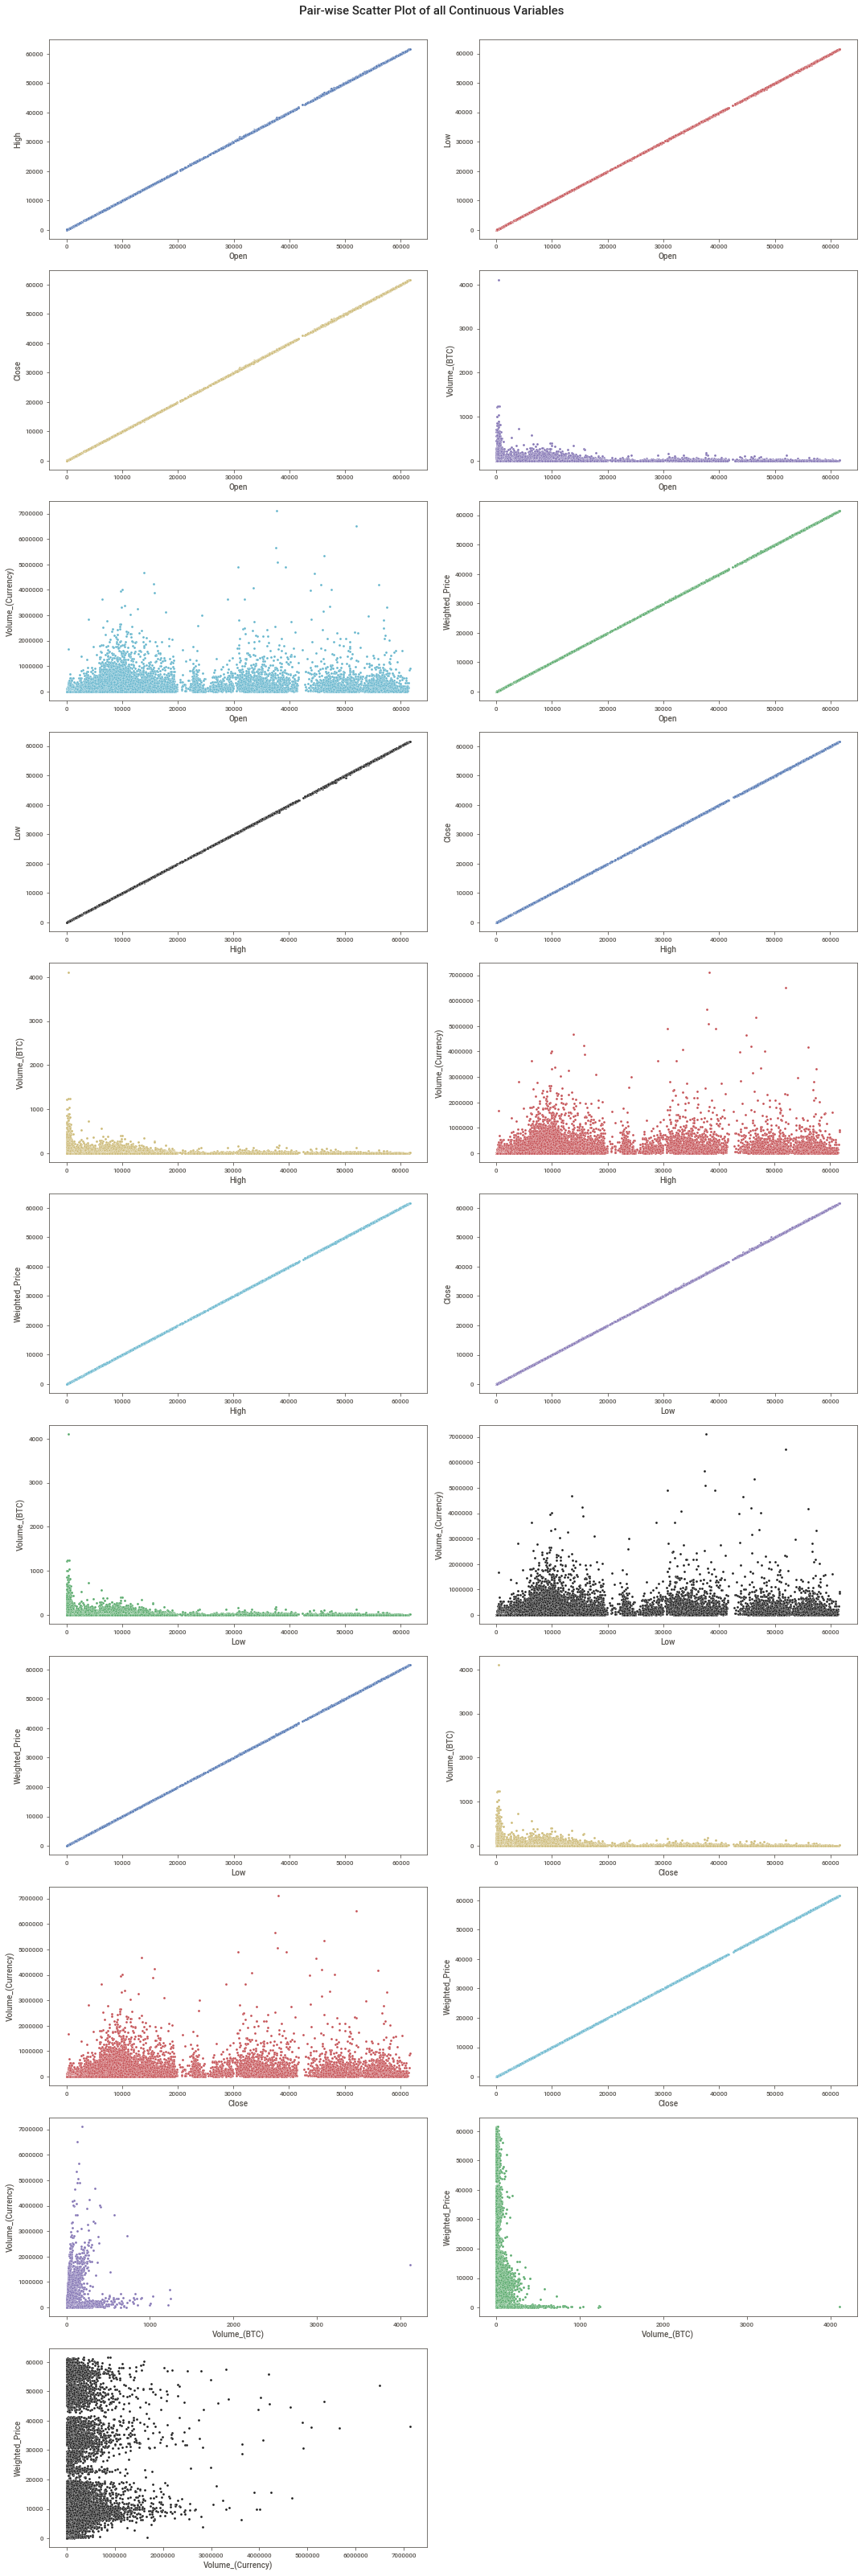

Could not draw Violin Plot


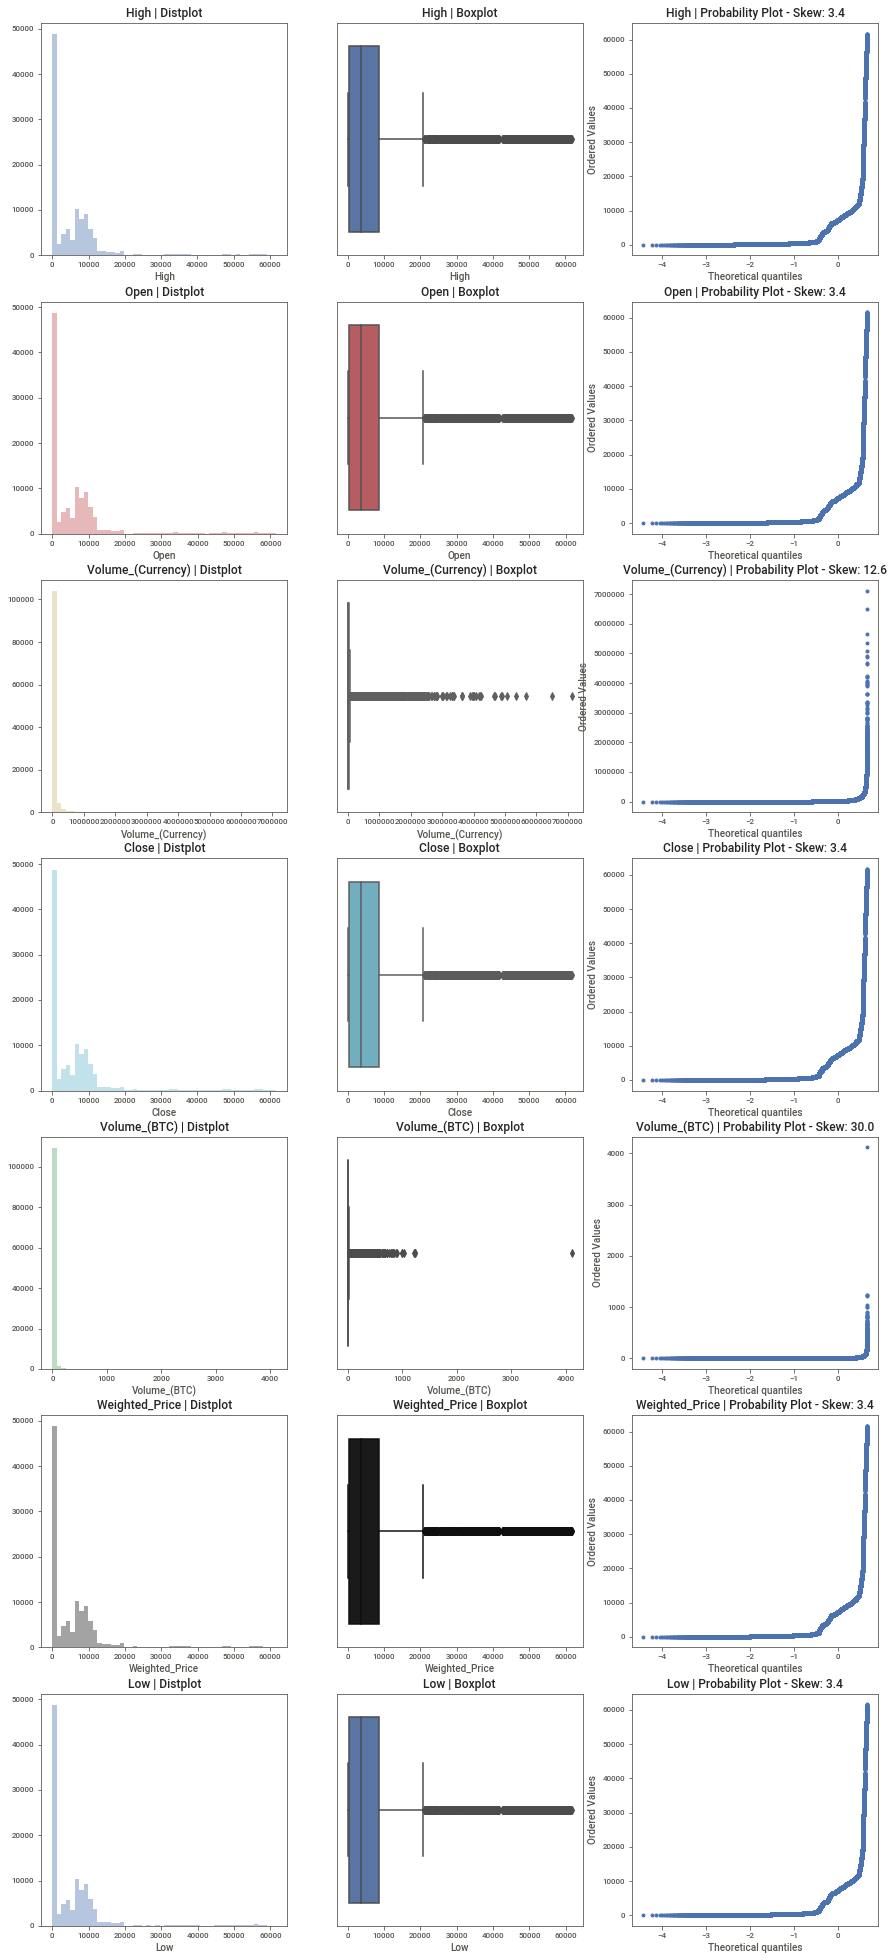

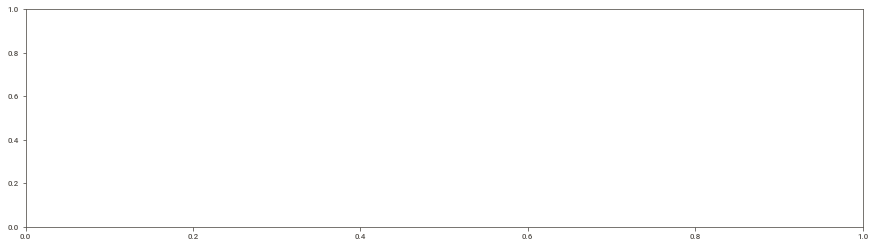

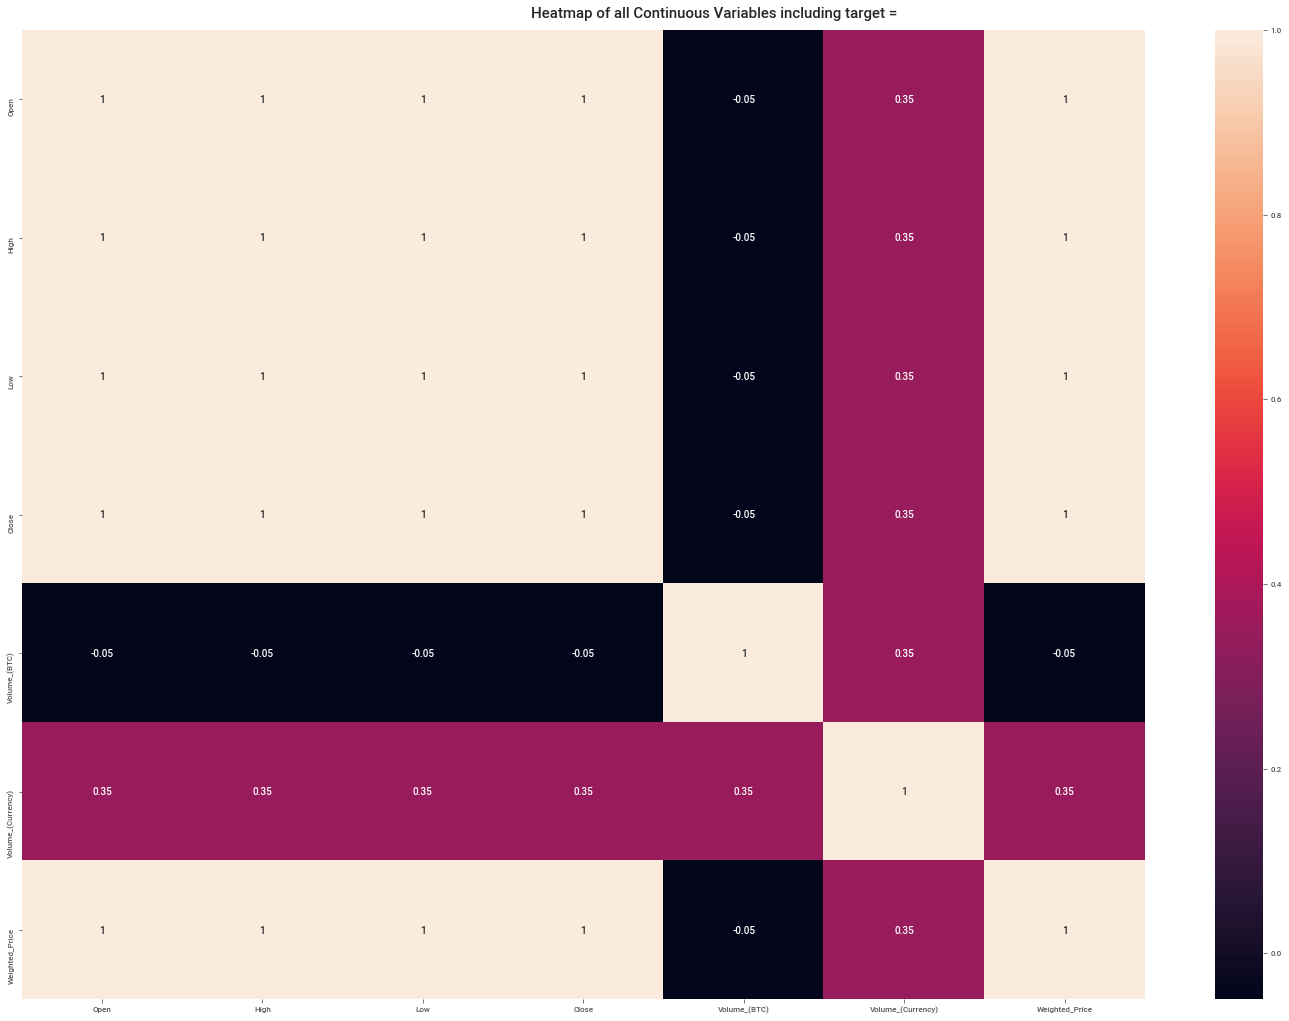

No categorical or numeric vars in data set. Hence no bar charts.
Time to run AutoViz (in seconds) = 25.997

 ###################### VISUALIZATION Completed ########################


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2599048,779.06,779.06,778.33,778.36,0.033832,26.343201,778.637328
4839110,58466.85,58466.85,58428.34,58442.98,0.462820,27044.547317,58434.327311
2049285,359.00,359.32,359.00,359.32,1.918973,689.105394,359.101216
600943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2113554,446.15,446.19,446.15,446.19,2.212535,987.167294,446.170173
...,...,...,...,...,...,...,...
4586220,10490.88,10494.85,10489.14,10489.14,0.225103,2362.304177,10494.307427
1989903,270.06,270.06,270.06,270.06,0.644899,174.161367,270.060000
1828413,245.44,245.44,245.28,245.28,4.824523,1183.470330,245.303072
4485960,9209.43,9209.94,9205.61,9205.61,0.032041,295.012000,9207.353964


In [27]:
'''ALGUNS GRAFICOS GERAIS DO DATASET'''

AV = AutoViz_Class()
AV.AutoViz ('/content/drive/MyDrive/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')


# Pré-Processamento dos Dados

De seguida realizamos um pequeno pré-processamento dos dados. 

Criamos uma nova coluna em formato datetime através da coluna original timestamp. Aqui tinhamos duas soluções, não executar mais nenhuma alteração e utilizar 4 milhões de elementos para a resolução do nosso problema, o que iria tornar a construção dos modelos muito lenta. Ou agrupar os elementos pela sua data de forma a reduzir a dimensão do dataset e assim reduzir a complexidade do treino.

Para este projeto devido ao nosso recursos de hardware reduzidos optamos pela segunda opção.

Para além disso, como o nosso problema é univariável, removemos todas as variáveis com exceção da que contém o valor da bitcoin e também removemos os elementos com a coluna vazia

In [28]:
#create a new pandas column to convert timestamp to date and group rows by date
#after that drop all except Weighted_Price that will be the atribute to predict
def prepare_data(df):
  #usar este para implementaçoes mais rapidas porque so tem 800 elementos
  df["Date"] = pd.to_datetime(df["Timestamp"],unit="s").dt.date
  #df["Date"] = pd.to_datetime(df["Timestamp"],unit="s")
  
  #selecionar os not NAN
  df = df[df["Weighted_Price"].notna()]

  df=df.groupby("Date").mean()  
  df = df.drop(columns=['Timestamp', 'Open', 'High', 'Low','Close', 'Volume_(BTC)', 'Volume_(Currency)'], inplace=False)
  return df

df = prepare_data(df)

# Criação da janela temporal

Agora como estamos a tratar um problema de séries temporais, é  necesssário criar uma janela temporal para cada elemento do dataset, ou seja, é necessário para cada elemento guardar os k elementos anteriores

Exemplificando: Com esta lista de inteiros [1,2,3,4,5,6,7,8] caso o número de timesteps k seja 4 por janela

[1,2,3,4]

[2,3,4,5]

[3,4,5,6] 

[4,5,6,7] 

[5,6,7,8]   


In [29]:
#build time series windows and split in predictores and labels
def to_supervised(df, timesteps):
  data = df.values
  x, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      x.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])  
  #using np.float32 for GPU performance
  return np.array(x).astype('float32'), np.array(y).astype('float32')

De modo a criarmos os modelos de previsão definimos três funções que permitem definir os modelos.

Implementamos duas funçoes que criam RNN (LSTM e GRU) e uma que cria uma CNN.
Todas elas utilizam o método de aprendizagem Adam com a mae como loss function

In [30]:
#define the DL models
def build_lstm(timesteps, h_neurons=64 ,features=1):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons,activation='relu', return_sequences=True,  input_shape=(timesteps,features)))
  model.add(tf.keras.layers.LSTM(h_neurons,activation='relu'))
  model.add(tf.keras.layers.Dense(units=32, activation='relu')),
  model.add(tf.keras.layers.Dense(1))
  #compile
  model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = 'mae')
  return model

def build_gru(timesteps, h_neurons=64 ,features=1):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GRU(h_neurons,activation='relu', return_sequences=True,  input_shape=(timesteps,features)))
  model.add(tf.keras.layers.GRU(h_neurons,activation='relu'))
  model.add(tf.keras.layers.Dense(units=32, activation='relu')),
  model.add(tf.keras.layers.Dense(1))
  #compile
  model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = 'mae')
  return model

def build_cnn(timesteps,features=1,filters=16, kernel_size=5, pool_size=2):
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,activation='relu', data_format='channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size=pool_size,data_format='channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = 'mae')
  return model

# Treino e previsão dos modelos e seus resultados

De seguida definimos funçoes capazes de treinar e realizar a previsão dos modelos

Em primeiro lugar criamos um função, split_data(), para separar 10% dos dados de treino para validação.

Também criamos uma função fit() capaz de treinar e que devolve o modelo treinado, a evolução do seu desempenho ao longo do treino e também a avaliação do modelo no dataset de teste

Para além disso definimos duas funções, uma para realizar previsões sobre o modelo (predict) e para realizar previsões sobre o modelo apartir do ultimo elemento do dataset de treino (forecast)




In [31]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

#train DL model with train dataset and evaluate with test dataset
#return model and performance
def fit(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size):
  #fit

  history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
  epochs=epochs, batch_size=batch_size, shuffle=False)
  metrics = model.evaluate(X_test, y_test)
  hist_list=history
  loss=metrics[1]

  return model, hist_list, loss

#predict the next step of sequence
def predict(model, X_test):
    return  model.predict(X_test)[:, 0][..., np.newaxis]

#predict the next 30 days  since the last train dataset element
def forecast(model, df, timesteps):
  input_seq = df[-timesteps:].to_numpy() #getting the last sequence of known value
  inp = input_seq
  next_days = []
  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, 30+1):
      inp=inp.reshape(1,timesteps,1)
      yhat= model.predict(inp)
      next_days.append(yhat)
      inp=np.append(inp[0],yhat)
      inp=inp[-timesteps:]
  return np.reshape(next_days,(len(next_days),1))

Agora, realizamos a otimização de hiper-parametros dos modelos.

Para os modelos com LSTM e GRU, otimizamos o numero de neuronios, o numero de timesteps e o batchsize. 

Já na CNN otimizamos o número de timesteps e o batchsize.


In [ ]:
#lstm otimization, find the best hiperr-parameters like batch_size, timesteps and h_neurons
epochs=10
lstm_best_params=[]
for timesteps in range(5,11):
  x, y = to_supervised(df, timesteps)
  print("Training shape:", x.shape)
  print("Training labels shape:", y.shape)
  
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=3)
  for train_index, test_index in tscv.split(x): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

  X_train, y_train = x[train_idx], y[train_idx]
  X_val, y_val = x[val_idx], y[val_idx]
  X_test, y_test = x[test_index], y[test_index]

  for batch_size in [7,14,21]:
    for h_neurons in [64,128,256]:
      model=build_lstm(timesteps, h_neurons)
      lstm, hist_lstm, loss_lstm = fit(model,X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size) 
      lstm_best_params.append("Timesteps %d - Batch_size %d - H_neurons %d - Score - %d" % (timesteps, batch_size, h_neurons,loss_lstm))

    
print(lstm_best_params)

In [ ]:
#gru otimization, find the best hiper-parameters like batch_size, timesteps and h_neurons
epochs=10
gru_best_params=[]
for timesteps in range(5,11):
  x, y = to_supervised(df, timesteps)
  print("Training shape:", x.shape)
  print("Training labels shape:", y.shape)
  
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=3)
  for train_index, test_index in tscv.split(x): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

  X_train, y_train = x[train_idx], y[train_idx]
  X_val, y_val = x[val_idx], y[val_idx]
  X_test, y_test = x[test_index], y[test_index]
  
  for batch_size in [7,14,21]:
    for h_neurons in [64,128,256]:
      model=build_gru(timesteps, h_neurons)
      gru, hist_gru, loss_gru= fit(model,X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size) 
      gru_best_params.append("Timesteps %d - Batch_size %d - H_neurons %d - Score - %d" % (timesteps, batch_size, h_neurons,loss_gru))
   
print(gru_best_params)

In [ ]:
#cnn otimization, find the best hiperr-parameters like batch_size, timesteps 
epochs=1
cnn_best_params=[]
for timesteps in range(5,11):
  x, y = to_supervised(df, timesteps)
  print("Training shape:", x.shape)
  print("Training labels shape:", y.shape)
  
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=3)
  for train_index, test_index in tscv.split(x): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

  X_train, y_train = x[train_idx], y[train_idx]
  X_val, y_val = x[val_idx], y[val_idx]
  X_test, y_test = x[test_index], y[test_index]
  
  for batch_size in [7,15,21]:
    model=build_cnn(timesteps)
    cnn, hist_cnn, loss_cnn = fit(model,X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size) 
    cnn_best_params.append("Timesteps %d - Batch_size %d - H_neurons %d - Score - %d" % (timesteps, batch_size, h_neurons,loss_cnn))
 
print(cnn_best_params)

Agora que obtivemos os hiper-parametros, vamos treinar os 3 modelos com os mesmos, prever-los e realizar o forecast para os próximos 30 dias

Training shape: (3370, 5, 1)
Training labels shape: (3370, 1)
Epoch 1/20
109/109 [==============================] - 7s 23ms/step - loss: 23.8685 - mae: 23.8685 - val_loss: 419.0191 - val_mae: 419.0191
Epoch 2/20
109/109 [==============================] - 2s 20ms/step - loss: 22.5943 - mae: 22.5943 - val_loss: 960.4374 - val_mae: 960.4374
Epoch 3/20
109/109 [==============================] - 2s 20ms/step - loss: 25.7620 - mae: 25.7620 - val_loss: 703.0565 - val_mae: 703.0565
Epoch 4/20
109/109 [==============================] - 2s 20ms/step - loss: 23.6850 - mae: 23.6850 - val_loss: 513.6730 - val_mae: 513.6730
Epoch 5/20
109/109 [==============================] - 2s 21ms/step - loss: 27.0271 - mae: 27.0271 - val_loss: 1085.1953 - val_mae: 1085.1953
Epoch 6/20
109/109 [==============================] - 2s 21ms/step - loss: 19.1600 - mae: 19.1600 - val_loss: 900.1805 - val_mae: 900.1805
Epoch 7/20
109/109 [==============================] - 2s 20ms/step - loss: 24.1503 - mae: 24.1503 - va

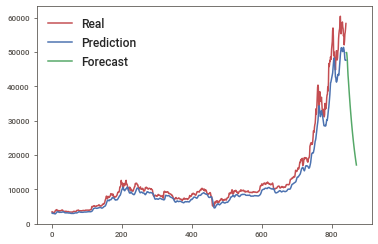

In [32]:
#fit, predict and forecast lstm with best params
timesteps=5
h_neurons=256
batch_size=21
epochs=20

x, y = to_supervised(df, timesteps)
print("Training shape:", x.shape)
print("Training labels shape:", y.shape)
    
#Time Series Cross Validator
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(x): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

X_train, y_train = x[train_idx], y[train_idx]
X_val, y_val = x[val_idx], y[val_idx]
X_test, y_test = x[test_index], y[test_index]

lstm = build_lstm(timesteps,h_neurons)
lstm, hist_lstm, loss_lstm = fit(lstm,X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size) 

y_pred = predict(lstm, X_test)  

next_days=forecast(lstm,df,timesteps)

plt.plot(range(len(y_test)),y_test,"r-", label="Real")
plt.plot(range(len(y_pred)), y_pred, "b-",label="Prediction")
plt.plot(range(len(y_pred),len(y_pred)+len(next_days)), next_days, "g-",label="Forecast")
plt.legend(fontsize=12)
plt.savefig('lstm_graph')
plt.show()

Training shape: (3367, 8, 1)
Training labels shape: (3367, 1)
Epoch 1/20
109/109 [==============================] - 6s 39ms/step - loss: 25.3787 - mae: 25.3787 - val_loss: 1033.5878 - val_mae: 1033.5878
Epoch 2/20
109/109 [==============================] - 4s 37ms/step - loss: 12.5750 - mae: 12.5750 - val_loss: 218.3139 - val_mae: 218.3139
Epoch 3/20
109/109 [==============================] - 4s 36ms/step - loss: 11.5603 - mae: 11.5603 - val_loss: 242.4451 - val_mae: 242.4451
Epoch 4/20
109/109 [==============================] - 4s 36ms/step - loss: 11.9902 - mae: 11.9902 - val_loss: 283.5302 - val_mae: 283.5302
Epoch 5/20
109/109 [==============================] - 4s 36ms/step - loss: 13.7219 - mae: 13.7219 - val_loss: 186.9879 - val_mae: 186.9879
Epoch 6/20
109/109 [==============================] - 4s 36ms/step - loss: 12.6395 - mae: 12.6395 - val_loss: 247.0790 - val_mae: 247.0790
Epoch 7/20
109/109 [==============================] - 4s 37ms/step - loss: 12.9047 - mae: 12.9047 - va

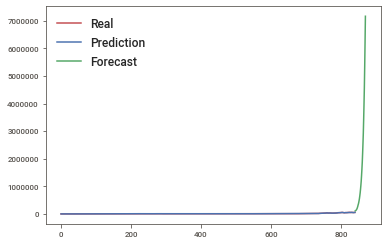

In [33]:
#fit, predict and forecast gru with best params
timesteps=8
h_neurons=256
batch_size=21
epochs=20

x, y = to_supervised(df, timesteps)
print("Training shape:", x.shape)
print("Training labels shape:", y.shape)
    
#Time Series Cross Validator
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(x): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

X_train, y_train = x[train_idx], y[train_idx]
X_val, y_val = x[val_idx], y[val_idx]
X_test, y_test = x[test_index], y[test_index]

gru= build_gru(timesteps,h_neurons)
gru, hist_gru, loss_gru = fit(gru,X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size) 

y_pred = predict(gru, X_test)  

next_days=forecast(lstm,df,timesteps)

plt.plot(range(len(y_test)),y_test,"r-", label="Real")
plt.plot(range(len(y_pred)), y_pred, "b-",label="Prediction")
plt.plot(range(len(y_pred),len(y_pred)+len(next_days)), next_days, "g-",label="Forecast")
plt.legend(fontsize=12)
plt.savefig('gru_graph')
plt.show()

Training shape: (3369, 6, 1)
Training labels shape: (3369, 1)
Epoch 1/20
325/325 [==============================] - 30s 3ms/step - loss: 24.2902 - mae: 24.2902 - val_loss: 915.2626 - val_mae: 915.2626
Epoch 2/20
325/325 [==============================] - 1s 2ms/step - loss: 16.4428 - mae: 16.4428 - val_loss: 718.5958 - val_mae: 718.5958
Epoch 3/20
325/325 [==============================] - 1s 2ms/step - loss: 16.2313 - mae: 16.2313 - val_loss: 648.4934 - val_mae: 648.4934
Epoch 4/20
325/325 [==============================] - 1s 2ms/step - loss: 16.1721 - mae: 16.1721 - val_loss: 667.0505 - val_mae: 667.0505
Epoch 5/20
325/325 [==============================] - 1s 2ms/step - loss: 16.0009 - mae: 16.0009 - val_loss: 696.2815 - val_mae: 696.2815
Epoch 6/20
325/325 [==============================] - 1s 3ms/step - loss: 15.3485 - mae: 15.3485 - val_loss: 600.6920 - val_mae: 600.6920
Epoch 7/20
325/325 [==============================] - 1s 2ms/step - loss: 15.6834 - mae: 15.6834 - val_loss: 

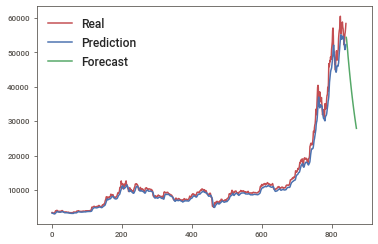

In [34]:
#fit, predict and forecast cnn with best params
timesteps=6
batch_size=7
epochs=20

x, y = to_supervised(df, timesteps)
print("Training shape:", x.shape)
print("Training labels shape:", y.shape)
    
#Time Series Cross Validator
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(x): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

X_train, y_train = x[train_idx], y[train_idx]
X_val, y_val = x[val_idx], y[val_idx]
X_test, y_test = x[test_index], y[test_index]

cnn = build_cnn(timesteps)
cnn, hist_cnn, loss_cnn = fit(cnn,X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size) 

y_pred = predict(cnn, X_test)  

next_days=forecast(cnn,df,timesteps)

plt.plot(range(len(y_test)),y_test,"r-", label="Real")
plt.plot(range(len(y_pred)), y_pred, "b-",label="Prediction")
plt.plot(range(len(y_pred),len(y_pred)+len(next_days)), next_days, "g-",label="Forecast")
plt.legend(fontsize=12)
plt.savefig('cnn_graph')
plt.show()

Para terminar apresentamos a evolução da performance dos 3 modelos ao longo do seu treino

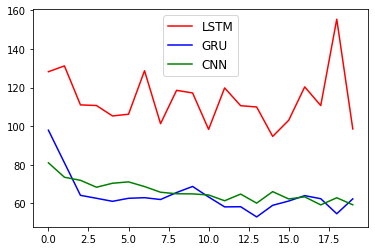

In [ ]:
plt.plot(range(len(hist_lstm.history['mae'])),hist_lstm.history['mae'],"r-", label="LSTM")
plt.plot(range(len(hist_gru.history['mae'])),hist_gru.history['mae'], "b-",label="GRU")
plt.plot(range(len(hist_cnn.history['mae'])),hist_cnn.history['mae'], "g-",label="CNN")
plt.legend(fontsize=12)
plt.savefig('results_mae')
plt.show()